In [1]:
import os
import numpy as np
import re
from matplotlib import pyplot
from scipy import optimize
from scipy.io import loadmat
%matplotlib inline


In [2]:
def plotData(X, y, grid=False):
    """
    Plots the data points X and y into a new figure. Uses `+` for positive examples, and `o` for
    negative examples. `X` is assumed to be a Mx2 matrix
    Parameters
    ----------
    X : numpy ndarray
        X is assumed to be a Mx2 matrix.
    y : numpy ndarray
        The data labels.
    grid : bool (Optional)
        Specify whether or not to show the grid in the plot. It is False by default.
    Notes
    -----
    This was slightly modified such that it expects y=1 or y=0.
    """
    # Find Indices of Positive and Negative Examples
    pos = y == 1
    neg = y == 0

    # Plot Examples
    pyplot.plot(X[pos, 0], X[pos, 1], 'X', mew=1, ms=10, mec='k')
    pyplot.plot(X[neg, 0], X[neg, 1], 'o', mew=1, mfc='y', ms=10, mec='k')
    pyplot.grid(grid)


In [3]:
def svmTrain(X, Y, C, kernelFunction, tol=1e-3, max_passes=5, args=()):
    """
    Trains an SVM classifier using a  simplified version of the SMO algorithm.
    Parameters
    ---------
    X : numpy ndarray
        (m x n) Matrix of training examples. Each row is a training example, and the
        jth column holds the jth feature.
    Y : numpy ndarray
        (m, ) A vector (1-D numpy array) containing 1 for positive examples and 0 for negative examples.
    C : float
        The standard SVM regularization parameter.
    kernelFunction : func
        A function handle which computes the kernel. The function should accept two vectors as
        inputs, and returns a scalar as output.
    tol : float, optional
        Tolerance value used for determining equality of floating point numbers.
    max_passes : int, optional
        Controls the number of iterations over the dataset (without changes to alpha)
        before the algorithm quits.
    args : tuple
        Extra arguments required for the kernel function, such as the sigma parameter for a
        Gaussian kernel.
    Returns
    -------
    model :
        The trained SVM model.
    Notes
    -----
    This is a simplified version of the SMO algorithm for training SVMs. In practice, if
    you want to train an SVM classifier, we recommend using an optimized package such as:
    - LIBSVM   (http://www.csie.ntu.edu.tw/~cjlin/libsvm/)
    - SVMLight (http://svmlight.joachims.org/)
    - scikit-learn (http://scikit-learn.org/stable/modules/svm.html) which contains python wrappers
    for the LIBSVM library.
    """
    # make sure data is signed int
    Y = Y.astype(int)
    # Dataset size parameters
    m, n = X.shape

    passes = 0
    E = np.zeros(m)
    alphas = np.zeros(m)
    b = 0

    # Map 0 to -1
    Y[Y == 0] = -1

    # Pre-compute the Kernel Matrix since our dataset is small
    # (in practice, optimized SVM packages that handle large datasets
    # gracefully will **not** do this)

    # We have implemented the optimized vectorized version of the Kernels here so
    # that the SVM training will run faster
    if kernelFunction.__name__ == 'linearKernel':
        # Vectorized computation for the linear kernel
        # This is equivalent to computing the kernel on every pair of examples
        K = np.dot(X, X.T)
    elif kernelFunction.__name__ == 'gaussianKernel':
        # vectorized RBF Kernel
        # This is equivalent to computing the kernel on every pair of examples
        X2 = np.sum(X**2, axis=1)
        K = X2 + X2[:, None] - 2 * np.dot(X, X.T)

        if len(args) > 0:
            K /= 2*args[0]**2

        K = np.exp(-K)
    else:
        K = np.zeros((m, m))
        for i in range(m):
            for j in range(i, m):
                K[i, j] = kernelFunction(X[i, :], X[j, :])
                K[j, i] = K[i, j]

    while passes < max_passes:
        num_changed_alphas = 0
        for i in range(m):
            E[i] = b + np.sum(alphas * Y * K[:, i]) - Y[i]

            if (Y[i]*E[i] < -tol and alphas[i] < C) or (Y[i]*E[i] > tol and alphas[i] > 0):
                # select the alpha_j randomly
                j = np.random.choice(list(range(i)) + list(range(i+1, m)), size=1)[0]

                E[j] = b + np.sum(alphas * Y * K[:, j]) - Y[j]

                alpha_i_old = alphas[i]
                alpha_j_old = alphas[j]

                if Y[i] == Y[j]:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                else:
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])

                if L == H:
                    continue

                eta = 2 * K[i, j] - K[i, i] - K[j, j]

                # objective function positive definite, there will be a minimum along the direction
                # of linear equality constrain, and eta will be greater than zero
                # we are actually computing -eta here (so we skip of eta >= 0)
                if eta >= 0:
                    continue

                alphas[j] -= Y[j] * (E[i] - E[j])/eta
                alphas[j] = max(L, min(H, alphas[j]))

                if abs(alphas[j] - alpha_j_old) < tol:
                    alphas[j] = alpha_j_old
                    continue
                alphas[i] += Y[i]*Y[j]*(alpha_j_old - alphas[j])

                b1 = b - E[i] - Y[i]*(alphas[i] - alpha_i_old) * K[i, j] \
                     - Y[j] * (alphas[j] - alpha_j_old) * K[i, j]

                b2 = b - E[j] - Y[i]*(alphas[i] - alpha_i_old) * K[i, j] \
                     - Y[j] * (alphas[j] - alpha_j_old) * K[j, j]

                if 0 < alphas[i] < C:
                    b = b1
                elif 0 < alphas[j] < C:
                    b = b2
                else:
                    b = (b1 + b2)/2

                num_changed_alphas += 1
        if num_changed_alphas == 0:
            passes += 1
        else:
            passes = 0

    idx = alphas > 0
    model = {'X': X[idx, :],
             'y': Y[idx],
             'kernelFunction': kernelFunction,
             'b': b,
             'args': args,
             'alphas': alphas[idx],
             'w': np.dot(alphas * Y, X)}
    return model


In [4]:
def svmPredict(model, X):
    """
    Returns a vector of predictions using a trained SVM model.
    Parameters
    ----------
    model : dict
        The parameters of the trained svm model, as returned by the function svmTrain
    X : array_like
        A (m x n) matrix where each example is a row.
    Returns
    -------
    pred : array_like
        A (m,) sized vector of predictions {0, 1} values.
    """
    # check if we are getting a vector. If so, then assume we only need to do predictions
    # for a single example
    if X.ndim == 1:
        X = X[np.newaxis, :]

    m = X.shape[0]
    p = np.zeros(m)
    pred = np.zeros(m)

    if model['kernelFunction'].__name__ == 'linearKernel':
        # we can use the weights and bias directly if working with the linear kernel
        p = np.dot(X, model['w']) + model['b']
    elif model['kernelFunction'].__name__ == 'gaussianKernel':
        # vectorized RBF Kernel
        # This is equivalent to computing the kernel on every pair of examples
        X1 = np.sum(X**2, 1)
        X2 = np.sum(model['X']**2, 1)
        K = X2 + X1[:, None] - 2 * np.dot(X, model['X'].T)

        if len(model['args']) > 0:
            K /= 2*model['args'][0]**2

        K = np.exp(-K)
        p = np.dot(K, model['alphas']*model['y']) + model['b']
    else:
        # other non-linear kernel
        for i in range(m):
            predictions = 0
            for j in range(model['X'].shape[0]):
                predictions += model['alphas'][j] * model['y'][j] \
                               * model['kernelFunction'](X[i, :], model['X'][j, :])
            p[i] = predictions

    pred[p >= 0] = 1
    return pred


In [5]:
def linearKernel(x1, x2):
    """
    Returns a linear kernel between x1 and x2.
    Parameters
    ----------
    x1 : numpy ndarray
        A 1-D vector.
    x2 : numpy ndarray
        A 1-D vector of same size as x1.
    Returns
    -------
    : float
        The scalar amplitude.
    """
    return np.dot(x1, x2)


In [6]:
def visualizeBoundaryLinear(X, y, model):
    """
    Plots a linear decision boundary learned by the SVM.
    Parameters
    ----------
    X : array_like
        (m x 2) The training data with two features (to plot in a 2-D plane).
    y : array_like
        (m, ) The data labels.
    model : dict
        Dictionary of model variables learned by SVM.
    """
    w, b = model['w'], model['b']
    xp = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
    yp = -(w[0] * xp + b)/w[1]

    plotData(X, y)
    pyplot.plot(xp, yp, '-b')


In [7]:
def visualizeBoundary(X, y, model):
    """
    Plots a non-linear decision boundary learned by the SVM and overlays the data on it.
    Parameters
    ----------
    X : array_like
        (m x 2) The training data with two features (to plot in a 2-D plane).
    y : array_like
        (m, ) The data labels.
    model : dict
        Dictionary of model variables learned by SVM.
    """
    plotData(X, y)

    # make classification predictions over a grid of values
    x1plot = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
    x2plot = np.linspace(min(X[:, 1]), max(X[:, 1]), 100)
    X1, X2 = np.meshgrid(x1plot, x2plot)

    vals = np.zeros(X1.shape)
    for i in range(X1.shape[1]):
        this_X = np.stack((X1[:, i], X2[:, i]), axis=1)
        vals[:, i] = svmPredict(model, this_X)

    pyplot.contour(X1, X2, vals, colors='y', linewidths=2)
    pyplot.pcolormesh(X1, X2, vals, cmap='YlGnBu', alpha=0.25, edgecolors='None', lw=0)
    pyplot.grid(False)


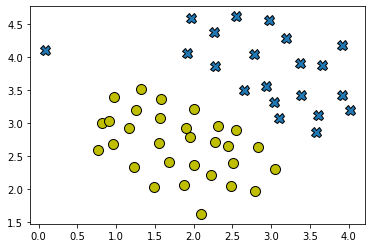

In [8]:
data = loadmat(os.path.join('ex6data1.mat'))
X, y = data['X'], data['y'][:, 0]

plotData(X, y)


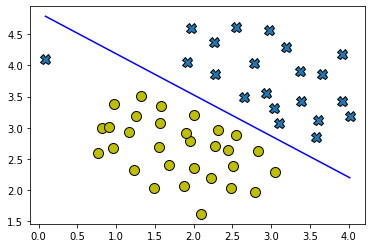

In [9]:
C = 1
model = svmTrain(X, y, C, linearKernel, 1e-3, 20)
visualizeBoundaryLinear(X, y, model)


In [10]:
def gaussianKernel(x1, x2, sigma):
    sim = 0
    sim = np.exp(np.sum((x1 - x2)*(x1 - x2))*(-1)/(2*sigma*sigma))
    return sim

In [11]:
x1 = np.array([1, 2, 1])
x2 = np.array([0, 4, -1])
sigma = 2

sim = gaussianKernel(x1, x2, sigma)

print('Gaussian Kernel between x1 = [1, 2, 1], x2 = [0, 4, -1], sigma = %0.2f:'
      '\n\t%f\n(for sigma = 2, this value should be about 0.324652)\n' % (sigma, sim))


Gaussian Kernel between x1 = [1, 2, 1], x2 = [0, 4, -1], sigma = 2.00:
	0.324652
(for sigma = 2, this value should be about 0.324652)



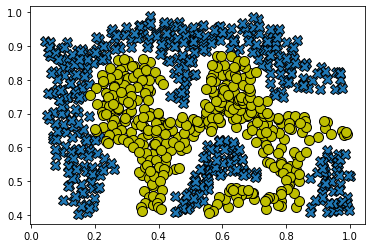

In [12]:
data = loadmat(os.path.join('ex6data2.mat'))
X, y = data['X'], data['y'][:, 0]

plotData(X, y)


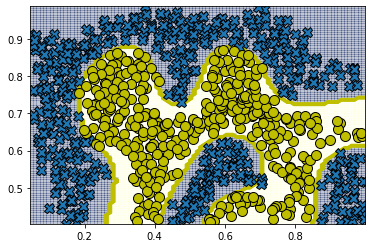

In [13]:
C = 1
sigma = 0.1

model= svmTrain(X, y, C, gaussianKernel, args=(sigma,))
visualizeBoundary(X, y, model)

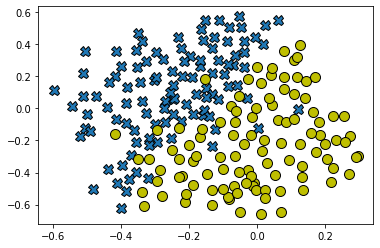

In [14]:
data = loadmat(os.path.join('ex6data3.mat'))
X, y, Xval, yval = data['X'], data['y'][:, 0], data['Xval'], data['yval'][:, 0]

plotData(X, y)


In [23]:
def dataset3Params(X, y, Xval, yval):
    C = 1
    sigma = 0.3
    C_val = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    sigma_val = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    results = np.zeros((64,3))
    count = 0
    for i in range (8):
        for j in range (8):
            model= svmTrain(X, y, C_val[i], gaussianKernel, args=(sigma_val[j],))
            pred = svmPredict(model,Xval)
            results[count,2] = np.mean(pred != yval)
            results[count,1] = sigma_val[j]
            results[count,0] = C_val[i]
            count = count + 1
    sorted_array = results[np.argsort(results[:,2])]
    C = sorted_array[0,0]
    sigma = sorted_array[0,1]
    return C, sigma


3.0 0.1


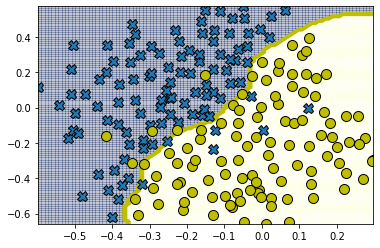

In [24]:
C, sigma = dataset3Params(X, y, Xval, yval)
model = svmTrain(X, y, C, gaussianKernel, args=(sigma,))
visualizeBoundary(X, y, model)
print(C, sigma)
